First, check your setup and packages match setup_script.md:

In [1]:
from lsst.rapid.analysis.utils import checkStackSetup
checkStackSetup()

/home/mfl/lsst/rapid_analysis/python/lsst/rapid/analysis/visitCheck.py:132: FutureWarning: Call to deprecated function (or staticmethod) timeMethod. (timeMethod has been replaced by lsst.utils.timer.timeMethod. Will be removed after v25.) -- Deprecated since version v24.
  def runDataRef(self, dataRef):


You are running w_2022_09 of lsst_distrib

Locally setup packages:
-----------------------
atmospec setup at /home/mfl/lsst/atmospec
spectractor setup at /home/mfl/lsst/Spectractor
rapid_analysis setup at /home/mfl/lsst/rapid_analysis


Then make a butler, and add the recommended collection from the setup_script file.

In [2]:
collection = 'u/mfl/PCWG_processing_1'
import lsst.rapid.analysis.butlerUtils as bu
butler = bu.makeDefaultLatissButler('NCSA', extraCollections=[collection])

Next, we make a NightReporter object. This is just a useful little toy project (read: not well supported, but might be helpful) to help understand (and visualise) the night's observations. Try poking it to see what it does, some it it, _e.g._ reporter.printObsTable() is quite useful for getting a quick overview of the observations of the night.

In [3]:
dayObs = 20200315

In [4]:
from lsst.rapid.analysis.nightReport import NightReporter
reporter = NightReporter('NCSA', dayObs)

Loaded data for seqNums 1 to 343


In [5]:
%matplotlib inline

See what objects we looked at over the course of the selected dayObs, so that we can pick one that sampled a nice range of airmasses to examine further.

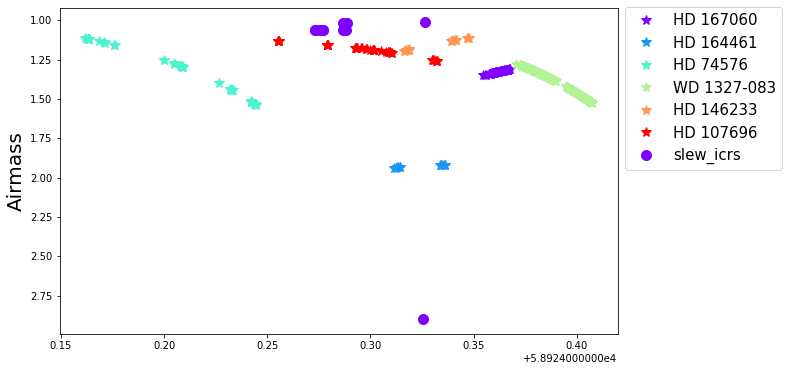

In [6]:
reporter.plotPerObjectAirMass()

In [7]:
objName = 'HD 74576'

Here we find out from the butler which sequence numbers are observations of that star. Note that a) some will be dispersed, but some will likely be direct images or donuts, etc, and that b) of the dispersed images, some might not have run all the way through the pipeline without failure, so we're going to need to test for that.

In [8]:
extraWhere = f'exposure.target_name="{objName}"'
seqNums = bu.getSeqNumsForDayObs(butler, dayObs, extraWhere)
print(f"Found {len(seqNums)} seqNums for object {objName}")

Found 69 seqNums for object HD 74576


Here, for the seqNums, we ask the butler to check if the output of Spectractor actually exists, such that it can be retrieved.

In [9]:
from lsst.rapid.analysis.utils import dayObsSeqNumToVisitId

In [10]:
extracted = []
for seqNum in seqNums:
    visitId = dayObsSeqNumToVisitId(dayObs, seqNum)
    if bu.datasetExists(butler, 'spectraction', dataId={'visit':visitId}, detector=0):
        extracted.append(seqNum)
print(f"Of the {len(seqNums)} images, spectractions were found for {len(extracted)} of them")

Of the 69 images, spectractions were found for 22 of them


Grab a random single result just so we've got an object to poke at, such that we can use it to help us write the code that follows.

In [11]:
visitId = dayObsSeqNumToVisitId(dayObs, extracted[0])
result = butler.get('spectraction', dataId=dict(visit=visitId), detector=0)

In [12]:
result.spectrum.header

SIMPLE  =                    T                                                  
BITPIX  =                  -64 / array data type                                
NAXIS   =                    2 / number of array dimensions                     
NAXIS1  =                  222                                                  
NAXIS2  =                    3                                                  
EXTEND  =                    T                                                  
TARGET  = 'HD 74576'           / name of the target in the image                
REDSHIFT= '4.3e-05 '           / redshift of the target                         
GRATING = 'ronchi90lpmm'       / name of the disperser                          
ROTANGLE=  -0.8733016487471204 / [deg] angle of the dispersion axis             
D2CCD   =    170.0259418128374 / [mm] distance between disperser and CCD        
LSHIFT  =                  0.0                                                  
PARANGLE=    80.726742246401

Build a dictionary of all the results for our sequence numbers:

(don't do this for too many or you'll run out of memory!)

In [13]:
results = {}
for seqNum in extracted:
    visitId = dayObsSeqNumToVisitId(dayObs, seqNum)
    results[seqNum] = butler.get('spectraction', dataId=dict(visit=visitId), detector=0)

Pick a random extraction, grab its lines, and see what their names are

In [14]:
for lineNum, line in enumerate(result.spectrum.lines.lines):
    print(lineNum, line.label)

0 $Fe_{I}$
1 $Ca_{II}$
2 $Ca_{II}$
3 $H\epsilon$
4 $H\delta$
5 $Fe_{I}$
6 $H\gamma$
7 $Fe_{I}$
8 $He_{I}$
9 $H\beta$
10 $Mg_{I}$
11 $Mg_{I}$
12 $Fe_{I}$
13 $H\alpha$
14 $O_2(B)$
15 
16 $O_2$
17 $O_2(Z)$
18 $O_2(Y)$
19 $H_2 O$


Now that we've poked a line to see how it quacks, lets look over all the extractions, pull the O2 line out, and plot its equivalent width against airmass

In [15]:
airmasses, eqWidths = [], []
for seqNum in results.keys():
    airmass = results[seqNum].spectrum.airmass
    line = [line for line in results[seqNum].spectrum.lines.lines if line.label=='$O_2$']
    eqWidth = line[0].fit_eqwidth_data
    airmasses.append(airmass)
    eqWidths.append(eqWidth)

In [16]:
import matplotlib.pyplot as plt

NB: This is a garbage in, garbage out situation. The current reductions are known-bad in many places, and this is just a toy example showing how one can access data, so don't freak out that it's bad!

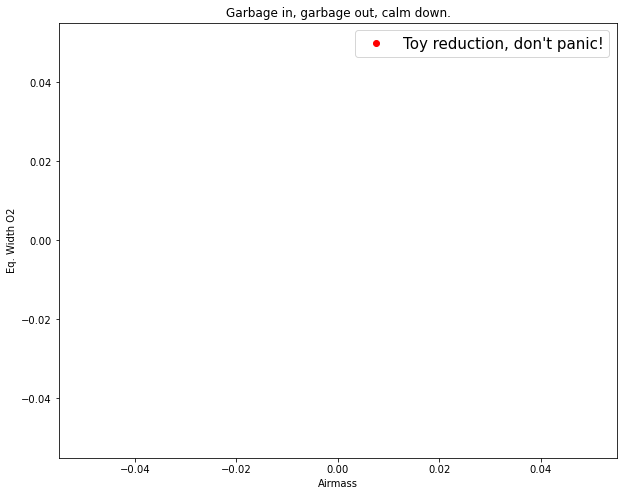

In [17]:
fig = plt.figure(figsize=(10, 8))
_ = plt.plot(airmasses, eqWidths, 'or', label="Toy reduction, don't panic!")
_ = plt.xlabel('Airmass')
_ = plt.ylabel('Eq. Width O2')
_ = plt.legend(fontsize=15)
_ = plt.title('Garbage in, garbage out, calm down.')